# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [13]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [14]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [15]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


##  Target Window Investigation
Here we will use a constant window size of 28 days to investigate model accuracy with increasing target window size

In [21]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d')
max_y_window = pd.Timedelta('14 days') # Predict if a bloom will occur within up to a 2 week window
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
y_windows = []


max_iter = 25000
loss = "log"

while current_y_window <= max_y_window:
    
    # Windowize
    print("current y window", current_y_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    y_windows.append(current_y_window)
    accuracies.append(accuracy)
    current_y_window += iteration_delta

current y window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8097643097643098
Test model recall: 0.7888040712468194
Test model precision: 0.9117647058823529

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8383838383838383
Test model recall: 0.8575063613231552
Test model precision: 0.8938992042440318

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.8215488215488216
Test model recall: 0.7455470737913485
Test model precision: 0.979933110367893

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.82154882154

Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Updating greedy model

Training model with: ['TMIN', 'PRCP', 'Temp C']
Test model accuracy: 0.8163265306122449
Test model recall: 0.8678304239401496
Test model precision: 0.8635235732009926

Training model with: ['TMIN', 'PRCP', 'ODOSat%']
Test model accuracy: 0.8537414965986394
Test model recall: 0.8029925187032418
Test model precision: 0.9787234042553191

Training model with: ['TMIN', 'PRCP', 'pH']
Test model accuracy: 0.8435374149659864
Test model recall: 0.942643391521197
Test model precision: 0.8456375838926175

Training model with: ['TMIN', 'PRCP', 'SNWD']
Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Training model with: ['TMIN', 'PRCP', 'SNOW']
Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Training model with: ['TM

Test model accuracy: 0.9086206896551724
Test model recall: 0.9176755447941889
Test model precision: 0.9522613065326633

Updating greedy model

Training model with: ['TMIN', 'rainy', 'SNOW']
Test model accuracy: 0.9086206896551724
Test model recall: 0.9176755447941889
Test model precision: 0.9522613065326633

Training model with: ['TMIN', 'rainy', 'pH (mV)']
Test model accuracy: 0.7293103448275862
Test model recall: 1.0
Test model precision: 0.724561403508772

Training model with: ['TMIN', 'rainy', 'Wind Speed']
Test model accuracy: 0.8982758620689655
Test model recall: 0.9200968523002422
Test model precision: 0.9359605911330049

Training model with: ['TMIN', 'rainy', 'ODO (mg/L)']
Test model accuracy: 0.8862068965517241
Test model recall: 0.8716707021791767
Test model precision: 0.9651474530831099

Training model with: ['TMIN', 'rainy', 'Wind Angle']
Test model accuracy: 0.7775862068965518
Test model recall: 0.7167070217917676
Test model precision: 0.961038961038961

Training model wit

Test model accuracy: 0.921602787456446
Test model recall: 0.9320843091334895
Test model precision: 0.961352657004831

Training model with: ['TMIN', 'rainy', 'PRCP', 'ODO (mg/L)']
Test model accuracy: 0.8832752613240418
Test model recall: 0.8805620608899297
Test model precision: 0.9591836734693877

Training model with: ['TMIN', 'rainy', 'PRCP', 'Sp Cond (uS/cm)']
Test model accuracy: 0.9198606271777003
Test model recall: 0.9578454332552693
Test model precision: 0.9359267734553776

Final greedy columns: ['TMIN', 'rainy', 'PRCP']
Final greedy accuracy 0.9250871080139372
Final greedy recall: 0.9672131147540983
Final greedy precision: 0.9343891402714932
Final greedy confusion matrix:
 [[118  29]
 [ 14 413]]
accuracy 0.9250871080139372
recall 0.9672131147540983
precision 0.9343891402714932
cm
 [[118  29]
 [ 14 413]]
current y window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extr

Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

base_columns: []
sorted_columns: ['TMAX', 'Temp C', 'ODOSat%', 'Wind Speed', 'SNWD', 'rainy', 'Wind Angle', 'SNOW', 'pH', 'PRCP', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMAX', 'Temp C', 'ODOSat%', 'Wind Speed', 'SNWD', 'rainy', 'Wind Angle', 'SNOW', 'pH', 'PRCP', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMAX']
Test model accuracy: 0.8280141843971631
Test model recall: 0.9765807962529274
Test model precision: 0.8273809523809523

Updating greedy model

Training model with: ['TM

Test model accuracy: 0.8327338129496403
Test model recall: 1.0
Test model precision: 0.8238636363636364

Updating greedy model

Training model with: ['Temp C', 'Wind Speed']
Test model accuracy: 0.8201438848920863
Test model recall: 1.0
Test model precision: 0.8130841121495327

Training model with: ['Temp C', 'SNWD']
Test model accuracy: 0.8327338129496403
Test model recall: 1.0
Test model precision: 0.8238636363636364

Training model with: ['Temp C', 'ODOSat%']
Test model accuracy: 0.789568345323741
Test model recall: 0.9954022988505747
Test model precision: 0.7901459854014599

Training model with: ['Temp C', 'rainy']
Test model accuracy: 0.8812949640287769
Test model recall: 0.8666666666666667
Test model precision: 0.9792207792207792

Updating greedy model

Training model with: ['Temp C', 'rainy', 'TMAX']
Test model accuracy: 0.8561151079136691
Test model recall: 0.8275862068965517
Test model precision: 0.9863013698630136

Training model with: ['Temp C', 'rainy', 'Wind Angle']
Test m

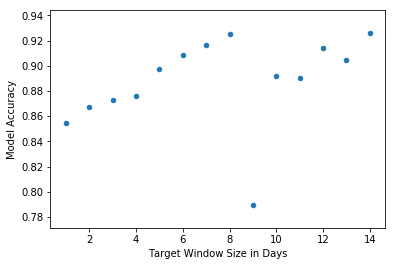

In [24]:
# Plot the accuracies vs y_window size
windows = [x.days for x in y_windows]
x = "Target Window Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: windows})
df.plot(kind="scatter", y=y, x=x)

In [25]:
# Cross validate the 8 day window model
# Windowize
base_columns = ['TMIN', 'rainy', 'PRCP']
current_x_window = pd.Timedelta('28 days')
current_y_window = pd.Timedelta('8 days')
current_separation = pd.Timedelta(0)
print("current y window", current_y_window)
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=current_x_window, y_win_size=current_y_window, 
    separation=current_separation)
train = train.append(hf.windowize(
    train_dfs[1], 'datetime', target_column, 
    x_win_size=current_x_window, y_win_size=current_y_window, 
    separation=current_separation))
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(
    test_dfs[0], 'datetime', target_column,
    x_win_size=current_x_window, y_win_size=current_y_window,
    separation=current_separation)
test = test.append(hf.windowize(
    test_dfs[1], 'datetime', target_column,
    x_win_size=current_x_window, y_win_size=current_y_window,
    separation=current_separation))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)

# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print("cm\n", cm)

current y window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.702803738317757
recall 0.8928571428571429
precision 0.7092198581560284
cm
 [[ 76 123]
 [ 36 300]]


##  Target Separation Investigation
Here we will use a constant x window size of 28 days to investigate model accuracy with increasing target separation size

In [25]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('13 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []


max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7962962962962963
Test model recall: 0.7983651226158038
Test model precision: 0.861764705882353

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7946127946127947
Test model recall: 0.7002724795640327
Test model precision: 0.9553903345724907

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8013468013468014
Test model recall: 0.8065395095367848
Test model precision: 0.8629737609329446

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'TMAX']
Test model accuracy: 0.7996632996632996
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8152542372881356
Test model recall: 0.8130081300813008
Test model precision: 0.8823529411764706

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8169491525423729
Test model recall: 0.8617886178861789
Test model precision: 0.848

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.8457627118644068
Test model recall: 0.8075880758807588
Test model precision: 0.9371069182389937

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX']
Test model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8061224489795918
Test model recall: 0.798941798941799
Test model precision: 0.888235294117647

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8061224489795918
Test model recall: 0.798941798941799
Test model precision: 0.888235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8095238095238095
Test model recall: 0.7301587301587301
Test model precision: 0.965034965034965

Updating greedy model

Training model with: ['TMIN', 'ODOSat%', 'TMAX']
Test model accuracy: 0.7755102040816326
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.761986301369863
Test model recall: 0.7115902964959568
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7586206896551724
Test model recall: 0.7038043478260869
Test model precision: 0.8931034482758621

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8172413793103448
Test model recall: 0.8125
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7504332755632582
Test model recall: 0.7021276595744681
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7578397212543554
Test model recall: 0.7082228116710876
Test model precision: 0.902027027027027

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8101045296167247
Test model recall: 0.78779840848806

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7701754385964912
Test model recall: 0.7193460490463215
Test model precision: 0.9041095890410958

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7912280701754386
Test model recall: 0.8065395095367

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8392226148409894
Test model recall: 0.8373983739837398
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7862190812720848
Test model recall: 0.7317073170731707
Test model precision: 0.9246575342465754

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.823321554770318
Test model recall: 0.8834688346883469
Test model precision: 0.8511749347258486

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7862190812720848
Test model recall: 0.79945799457994

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8404255319148937
Test model recall: 0.8306878306878307
Test model precision: 0.9235294117647059

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.776595744680851
Test model recall: 0.7195767195767195
Test model precision: 0.9315068493150684

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8439716312056738
Test model recall: 0.8809523809523809
Test model precision: 0.8856382978723404

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7890070921985816
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32978723404255317
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6453900709219859
Test model recall: 0.49206349206349204
Test model precision: 0.9587628865979382

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.524822695035461
Test model recall: 0.328042328042328
Test model precision: 0.8985507246376812

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8439716312056738
Final greedy recall: 0.8809523809523809
Final greedy precision: 0.8856382978723404
Final greedy confusion matrix:
 [[143  43]
 [ 45 333]]
accuracy 0.8439716312056738
recall 0.8809523809523809
precision 0.8856382978723404
cm
 [[143  43]
 [ 45 333]]
current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8410714285714286
Test model recall: 0.8382749326145552
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7732142857142857
Test model recall: 0.7277628032345014
Test model precision: 0.9121621621621622

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8517857142857143
Test model recall: 0.894878706199461
Test model precision: 0.8829787234042553

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7785714285714286
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3375
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6160714285714286
Test model recall: 0.4420485175202156
Test model precision: 0.9534883720930233

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.4142857142857143
Test model recall: 0.3018867924528302
Test model precision: 0.6187845303867403

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8517857142857143
Final greedy recall: 0.894878706199461
Final greedy precision: 0.8829787234042553
Final greedy confusion matrix:
 [[145  44]
 [ 39 332]]
accuracy 0.8517857142857143
recall 0.894878706199461
precision 0.8829787234042553
cm
 [[145  44]
 [ 39 332]]
current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining ext

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8453237410071942
Test model recall: 0.845108695652174
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7985611510791367
Test model recall: 0.7445652173913043
Test model precision: 0.9383561643835616

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8489208633093526
Test model recall: 0.907608695652174
Test model precision: 0.8697916666666666

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7320143884892086
Test m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3381294964028777
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.49280575539568344
Test model recall: 0.25
Test model precision: 0.9387755102040817

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2931654676258993
Test model recall: 0.20108695652173914
Test model precision: 0.4277456647398844

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8489208633093526
Final greedy recall: 0.907608695652174
Final greedy precision: 0.8697916666666666
Final greedy confusion matrix:
 [[138  50]
 [ 34 334]]
accuracy 0.8489208633093526
recall 0.907608695652174
precision 0.8697916666666666
cm
 [[138  50]
 [ 34 334]]
current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining ext

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8553345388788427
Test model recall: 0.8457446808510638
Test model precision: 0.9352941176470588

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7938517179023508
Test model recall: 0.7313829787234043
Test model precision: 0.9548611111111112

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8607594936708861
Test model recall: 0.925531914893617
Test model precision: 0.8765743073047859

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7504520795660036
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32007233273056057
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.47920433996383366
Test model recall: 0.24468085106382978
Test model precision: 0.9583333333333334

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.36347197106690776
Test model recall: 0.31648936170212766
Test model precision: 0.5560747663551402

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8607594936708861
Final greedy recall: 0.925531914893617
Final greedy precision: 0.8765743073047859
Final greedy confusion matrix:
 [[128  49]
 [ 28 348]]
accuracy 0.8607594936708861
recall 0.925531914893617
precision 0.8765743073047859
cm
 [[128  49]
 [ 28 348]]


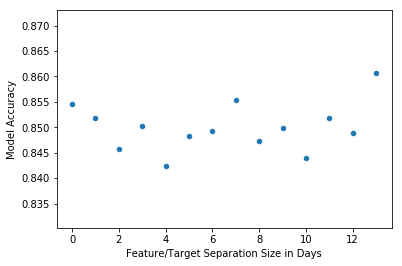

In [27]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)

##  Target Separation Investigation 6 weeks
Here we will use a constant x window size of 28 days to investigate model accuracy with increasing target separation size

In [28]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('42 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []


max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7962962962962963
Test model recall: 0.7983651226158038
Test model precision: 0.861764705882353

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7946127946127947
Test model recall: 0.7002724795640327
Test model precision: 0.9553903345724907

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8013468013468014
Test model recall: 0.8065395095367848
Test model precision: 0.8629737609329446

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8333333333333334
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8152542372881356
Test model recall: 0.8130081300813008
Test model precision: 0.8823529411764706

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8169491525423729
Test model recall: 0.8617886178861789
Test model precision: 0.848

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.8457627118644068
Test model recall: 0.8075880758807588
Test model precision: 0.9371069182389937

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX']
Test model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8061224489795918
Test model recall: 0.798941798941799
Test model precision: 0.888235294117647

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8095238095238095
Test model recall: 0.7301587301587301
Test model precision: 0.965034965034965

Updating greedy model

Training model with: ['TMIN', 'ODOSat%', 'Temp C']
Test model accuracy: 0.8384353741496599
Test model recall: 0.8121693121693122
Test model precision: 0.9274924471299094

Updating greedy model

Training model with: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX']

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.761986301369863
Test model recall: 0.7115902964959568
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7586206896551724
Test model recall: 0.7038043478260869
Test model precision: 0.8931034482758621

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8120689655172414
Test model recall: 0.8016304347826

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7504332755632582
Test model recall: 0.7021276595744681
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7578397212543554
Test model recall: 0.7082228116710876
Test model precision: 0.902027027027027

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8101045296167247
Test model recall: 0.78779840848806

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'pH', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'pH', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7701754385964912
Test model recall: 0.7193460490463215
Test model precision: 0.9041095890410958

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7912280701754386
Test model recall: 0.8065395095367

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8392226148409894
Test model recall: 0.8373983739837398
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7862190812720848
Test model recall: 0.7317073170731707
Test model precision: 0.9246575342465754

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.823321554770318
Test model recall: 0.8834688346883469
Test model precision: 0.8511749347258486

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7862190812720848
Test model recall: 0.79945799457994

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8404255319148937
Test model recall: 0.8306878306878307
Test model precision: 0.9235294117647059

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.776595744680851
Test model recall: 0.7195767195767195
Test model precision: 0.9315068493150684

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8439716312056738
Test model recall: 0.8809523809523809
Test model precision: 0.8856382978723404

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7890070921985816
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32978723404255317
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'ODO (mg/L)']
Test model accuracy: 0.7429078014184397
Test model recall: 0.7248677248677249
Test model precision: 0.8698412698412699

Training model with: ['TMIN', 'Temp C', 'SNOW']
Test model accuracy: 0.8439716312056738
Test model recall: 0.8809523809523809
Test model precision: 0.8856382978723404

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6453900709219859
Test model recall: 0.49206349206349204
Test model precision: 0.9587628865979382

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.5230496453900709
Test model recall: 0.3253968253968254
Test model precision: 0.8978102189781022

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8439716312056738
Final greedy recall: 0.8809523809523809
Final greedy precision: 0.8856382978723404
Final greedy confusion matrix:
 [[143  43]
 [ 45 333]]
a

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8410714285714286
Test model recall: 0.8382749326145552
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7732142857142857
Test model recall: 0.7277628032345014
Test model precision: 0.9121621621621622

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8517857142857143
Test model recall: 0.894878706199461
Test model precision: 0.8829787234042553

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7803571428571429
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3375
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'ODO (mg/L)']
Test model accuracy: 0.7107142857142857
Test model recall: 0.6900269541778976
Test model precision: 0.8448844884488449

Training model with: ['TMIN', 'Temp C', 'SNOW']
Test model accuracy: 0.8517857142857143
Test model recall: 0.894878706199461
Test model precision: 0.8829787234042553

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6053571428571428
Test model recall: 0.42587601078167114
Test model precision: 0.9518072289156626

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.41785714285714287
Test model recall: 0.3018867924528302
Test model precision: 0.6256983240223464

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8517857142857143
Final greedy recall: 0.894878706199461
Final greedy precision: 0.8829787234042553
Final greedy confusion matrix:
 [[145  44]
 [ 39 332]]
accuracy 0.8517

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8453237410071942
Test model recall: 0.845108695652174
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7985611510791367
Test model recall: 0.7445652173913043
Test model precision: 0.9383561643835616

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8489208633093526
Test model recall: 0.907608695652174
Test model precision: 0.8697916666666666

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7320143884892086
Test m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3381294964028777
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'SNOW']
Test model accuracy: 0.8489208633093526
Test model recall: 0.907608695652174
Test model precision: 0.8697916666666666

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.49280575539568344
Test model recall: 0.25
Test model precision: 0.9387755102040817

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2931654676258993
Test model recall: 0.20108695652173914
Test model precision: 0.4277456647398844

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8489208633093526
Final greedy recall: 0.907608695652174
Final greedy precision: 0.8697916666666666
Final greedy confusion matrix:
 [[138  50]
 [ 34 334]]
accuracy 0.8489208633093526
recall 0.907608695652174
precision 0.8697916666666666
cm
 [[138  50]
 [ 34 334]]
current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Ext

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'pH (mV)', 'SNOW', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8553345388788427
Test model recall: 0.8457446808510638
Test model precision: 0.9352941176470588

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7938517179023508
Test model recall: 0.7313829787234043
Test model precision: 0.9548611111111112

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8607594936708861
Test model recall: 0.925531914893617
Test model precision: 0.8765743073047859

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7522603978300181
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32007233273056057
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'SNOW']
Test model accuracy: 0.8607594936708861
Test model recall: 0.925531914893617
Test model precision: 0.8765743073047859

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.47920433996383366
Test model recall: 0.24468085106382978
Test model precision: 0.9583333333333334

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.36347197106690776
Test model recall: 0.31648936170212766
Test model precision: 0.5560747663551402

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8607594936708861
Final greedy recall: 0.925531914893617
Final greedy precision: 0.8765743073047859
Final greedy confusion matrix:
 [[128  49]
 [ 28 348]]
accuracy 0.8607594936708861
recall 0.925531914893617
precision 0.8765743073047859
cm
 [[128  49]
 [ 28 348]]
current separation 14 days 00:00:00
Windowizing 2017 data set: 0


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Speed', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Speed', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8418181818181818
Test model recall: 0.8355437665782494
Test model precision: 0.9264705882352942

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7909090909090909
Test model recall: 0.7427055702917772
Test model precision: 0.9395973154362416

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.84
Test model recall: 0.9310344827586207
Test model precision: 0.8498789346246973

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8345454545454546
Test model recall: 0.896551724137931
Test model pre

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3145454545454546
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8418181818181818
Test model recall: 0.8355437665782494
Test model precision: 0.9264705882352942

Training model with: ['TMIN', 'Wind Speed']
Test model accuracy: 0.8236363636363636
Test model recall: 0.7957559681697612
Test model precision: 0.9375

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.26181818181818184
Test model recall: 0.1856763925729443
Test model precision: 0.41420118343195267

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8418181818181818
Final greedy recall: 0.8355437665782494
Final greedy precision: 0.9264705882352942
Final greedy confusion matrix:
 [[148  25]
 [ 62 315]]
accuracy 0.8418181818181818
recall 0.8355437665782494
precision 0.9264705882352942
cm
 [[148  25]
 [ 62 315]]
current separation 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Speed', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Wind Speed', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8406593406593407
Test model recall: 0.8446866485013624
Test model precision: 0.9117647058823529

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8040293040293041
Test model recall: 0.7574931880108992
Test model precision: 0.9391891891891891

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8278388278388278
Test model recall: 0.9346049046321526
Test model precision: 0.8305084745762712

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8186813186813187
Test model recall: 0.9100817438692098

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32783882783882784
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8406593406593407
Test model recall: 0.8446866485013624
Test model precision: 0.9117647058823529

Training model with: ['TMIN', 'Wind Speed']
Test model accuracy: 0.8076923076923077
Test model recall: 0.7956403269754768
Test model precision: 0.906832298136646

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2326007326007326
Test model recall: 0.15803814713896458
Test model precision: 0.34523809523809523

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8406593406593407
Final greedy recall: 0.8446866485013624
Final greedy precision: 0.9117647058823529
Final greedy confusion matrix:
 [[149  30]
 [ 57 310]]
accuracy 0.8406593406593407
recall 0.8446866485013624
precision 0.9117647058823529
cm
 [[149  30]
 [ 57 310]]
current separation 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'ODOSat%', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'ODOSat%', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8321033210332104
Test model recall: 0.8373983739837398
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8173431734317343
Test model recall: 0.9132791327913279
Test model precision: 0.8341584158415841

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8099630996309963
Test model recall: 0.8021680216802168
Test model precision: 0.9079754601226994

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8210332103321033
Test model recall: 0.924119241192412


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3191881918819188
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8321033210332104
Test model recall: 0.8373983739837398
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.6789667896678967
Test model recall: 0.6612466124661247
Test model precision: 0.8327645051194539

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.25461254612546125
Test model recall: 0.2032520325203252
Test model precision: 0.40540540540540543

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8321033210332104
Final greedy recall: 0.8373983739837398
Final greedy precision: 0.9088235294117647
Final greedy confusion matrix:
 [[142  31]
 [ 60 309]]
accuracy 0.8321033210332104
recall 0.8373983739837398
precision 0.9088235294117647
cm
 [[142  31]
 [ 60 309]]
current separation 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature wi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'ODOSat%', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'pH', 'SNWD', 'pH (mV)', 'SNOW', 'ODOSat%', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8444444444444444
Test model recall: 0.8386243386243386
Test model precision: 0.9323529411764706

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.737037037037037
Test model recall: 0.7063492063492064
Test model precision: 0.8959731543624161

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8388888888888889
Test model recall: 0.9232804232804233
Test model precision: 0.8574938574938575

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8296296296296296
Test model recall: 0.9126984126984127


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8444444444444444
Test model recall: 0.8386243386243386
Test model precision: 0.9323529411764706

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.6722222222222223
Test model recall: 0.6428571428571429
Test model precision: 0.8526315789473684

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.23148148148148148
Test model recall: 0.19047619047619047
Test model precision: 0.39779005524861877

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8444444444444444
Final greedy recall: 0.8386243386243386
Final greedy precision: 0.9323529411764706
Final greedy confusion matrix:
 [[139  23]
 [ 61 317]]
accuracy 0.8444444444444444
recall 0.8386243386243386
precision 0.9323529411764706
cm
 [[139  23]
 [ 61 317]]
current separation 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extra

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'Wind Speed', 'rainy', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'Wind Speed', 'rainy', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8488805970149254
Test model recall: 0.8490566037735849
Test model precision: 0.9264705882352942

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7406716417910447
Test model recall: 0.7142857142857143
Test model precision: 0.889261744966443

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8283582089552238
Test model recall: 0.9191374663072777
Test model precision: 0.8461538461538461

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8264925373134329
Test model recall: 0.9191374663072777


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.30783582089552236
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8488805970149254
Test model recall: 0.8490566037735849
Test model precision: 0.9264705882352942

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2332089552238806
Test model recall: 0.18598382749326145
Test model precision: 0.38764044943820225

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8488805970149254
Final greedy recall: 0.8490566037735849
Final greedy precision: 0.9264705882352942
Final greedy confusion matrix:
 [[140  25]
 [ 56 315]]
accuracy 0.8488805970149254
recall 0.8490566037735849
precision 0.9264705882352942
cm
 [[140  25]
 [ 56 315]]
current separation 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8345864661654135
Test model recall: 0.842391304347826
Test model precision: 0.9117647058823529

Updating greedy model

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.8233082706766918
Test model recall: 0.9211956521739131
Test model precision: 0.8391089108910891

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7969924812030075
Test model recall: 0.7961956521739131
Test model precision: 0.8987730061349694

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8176691729323309
Test model recall: 0.9103260869565217


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3082706766917293
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8345864661654135
Test model recall: 0.842391304347826
Test model precision: 0.9117647058823529

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2387218045112782
Test model recall: 0.19021739130434784
Test model precision: 0.3954802259887006

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8345864661654135
Final greedy recall: 0.842391304347826
Final greedy precision: 0.9117647058823529
Final greedy confusion matrix:
 [[134  30]
 [ 58 310]]
accuracy 0.8345864661654135
recall 0.842391304347826
precision 0.9117647058823529
cm
 [[134  30]
 [ 58 310]]
current separation 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'PRCP', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'PRCP', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'SNWD', 'pH (mV)', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8355387523629489
Test model recall: 0.8373333333333334
Test model precision: 0.9235294117647059

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8052930056710775
Test model recall: 0.7973333333333333
Test model precision: 0.9171779141104295

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.7069943289224953
Test model recall: 0.7066666666666667
Test model precision: 0.8548387096774194

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8355387523629489
Test model recall: 0.888
Test model p

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.29111531190926276
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'SNOW']
Test model accuracy: 0.8355387523629489
Test model recall: 0.8373333333333334
Test model precision: 0.9235294117647059

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.24007561436672967
Test model recall: 0.2
Test model precision: 0.423728813559322

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8355387523629489
Final greedy recall: 0.8373333333333334
Final greedy precision: 0.9235294117647059
Final greedy confusion matrix:
 [[128  26]
 [ 61 314]]
accuracy 0.8355387523629489
recall 0.8373333333333334
precision 0.9235294117647059
cm
 [[128  26]
 [ 61 314]]
current separation 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'SNWD', 'SNOW', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'SNWD', 'SNOW', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'pH', 'ODOSat%', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8365019011406845
Test model recall: 0.839572192513369
Test model precision: 0.9235294117647059

Updating greedy model

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.7300380228136882
Test model recall: 0.7620320855614974
Test model precision: 0.8431952662721893

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8098859315589354
Test model recall: 0.8021390374331551
Test model precision: 0.9202453987730062

Training model with: ['TMIN', 'SNWD']
Test model accuracy: 0.8365019011406845
Test model recall: 0.839572192513369
Tes

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2889733840304182
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2414448669201521
Test model recall: 0.20320855614973263
Test model precision: 0.4293785310734463

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8365019011406845
Final greedy recall: 0.839572192513369
Final greedy precision: 0.9235294117647059
Final greedy confusion matrix:
 [[126  26]
 [ 60 314]]
accuracy 0.8365019011406845
recall 0.839572192513369
precision 0.9235294117647059
cm
 [[126  26]
 [ 60 314]]
current separation 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature w

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'SNWD', 'SNOW', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'pH', 'ODOSat%', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'PRCP', 'TMAX', 'Temp C', 'SNWD', 'SNOW', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'pH', 'ODOSat%', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8314176245210728
Test model recall: 0.8461538461538461
Test model precision: 0.9058823529411765

Updating greedy model

Training model with: ['TMIN', 'PRCP']
Test model accuracy: 0.7816091954022989
Test model recall: 0.8681318681318682
Test model precision: 0.8272251308900523

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8314176245210728
Test model recall: 0.8461538461538461
Test model precision: 0.9058823529411765

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7662835249042146
Test model recall: 0.9065934065934066

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.30268199233716475
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2509578544061303
Test model recall: 0.20604395604395603
Test model precision: 0.423728813559322

Final greedy columns: ['TMIN']
Final greedy accuracy 0.8314176245210728
Final greedy recall: 0.8461538461538461
Final greedy precision: 0.9058823529411765
Final greedy confusion matrix:
 [[126  32]
 [ 56 308]]
accuracy 0.8314176245210728
recall 0.8461538461538461
precision 0.9058823529411765
cm
 [[126  32]
 [ 56 308]]
current separation 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMAX', 'Temp C', 'PRCP', 'TMIN', 'SNWD', 'rainy', 'SNOW', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['TMAX', 'Temp C', 'PRCP', 'TMIN', 'SNWD', 'rainy', 'SNOW', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['TMAX']
Test model accuracy: 0.8552123552123552
Test model recall: 0.9095890410958904
Test model precision: 0.8877005347593583

Updating greedy model

Training model with: ['TMAX', 'Temp C']
Test model accuracy: 0.7934362934362934
Test model recall: 0.915068493150685
Test model precision: 0.8146341463414634

Training model with: ['TMAX', 'PRCP']
Test model accuracy: 0.7972972972972973
Test model recall: 0.9205479452054794
Test model precision: 0.8155339805825242

Training model with: ['TMAX', 'TMIN']
Test model accuracy: 0.8011583011583011
Test model recall: 0.8849315068493151


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2953667953667954
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['TMAX']
Final greedy accuracy 0.8552123552123552
Final greedy recall: 0.9095890410958904
Final greedy precision: 0.8877005347593583
Final greedy confusion matrix:
 [[111  42]
 [ 33 332]]
accuracy 0.8552123552123552
recall 0.9095890410958904
precision 0.8877005347593583
cm
 [[111  42]
 [ 33 332]]
current separation 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'rainy', 'SNOW', 'Temp C', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'rainy', 'SNOW', 'Temp C', 'ODO (mg/L)', 'Wind Angle', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8294573643410853
Test model recall: 0.9224598930481284
Test model precision: 0.8539603960396039

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.6550387596899225
Test model recall: 0.6925133689839572
Test model precision: 0.8043478260869565

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.7403100775193798
Test model recall: 0.7780748663101604
Test model precision: 0.8508771929824561

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8294573643410853
Test model recall: 0.9224598930481284
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2751937984496124
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8294573643410853
Final greedy recall: 0.9224598930481284
Final greedy precision: 0.8539603960396039
Final greedy confusion matrix:
 [[ 83  59]
 [ 29 345]]
accuracy 0.8294573643410853
recall 0.9224598930481284
precision 0.8539603960396039
cm
 [[ 83  59]
 [ 29 345]]
current separation 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'Temp C', 'SNWD', 'SNOW', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'Temp C', 'SNWD', 'SNOW', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.82421875
Test model recall: 0.9289617486338798
Test model precision: 0.8415841584158416

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.640625
Test model recall: 0.6775956284153005
Test model precision: 0.7898089171974523

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.75
Test model recall: 0.7923497267759563
Test model precision: 0.847953216374269

Training model with: ['PRCP', 'Temp C']
Test model accuracy: 0.744140625
Test model recall: 0.8360655737704918
Test model precision: 0.811671087533156

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.28515625
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.82421875
Final greedy recall: 0.9289617486338798
Final greedy precision: 0.8415841584158416
Final greedy confusion matrix:
 [[ 82  64]
 [ 26 340]]
accuracy 0.82421875
recall 0.9289617486338798
precision 0.8415841584158416
cm
 [[ 82  64]
 [ 26 340]]
current separation 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8188976377952756
Test model recall: 0.9285714285714286
Test model precision: 0.8366336633663366

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.6377952755905512
Test model recall: 0.6785714285714286
Test model precision: 0.7866242038216561

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.7834645669291339
Test model recall: 0.8708791208791209
Test model precision: 0.8342105263157895

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8188976377952756
Test model recall: 0.9285714285714286
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.28346456692913385
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8188976377952756
Final greedy recall: 0.9285714285714286
Final greedy precision: 0.8366336633663366
Final greedy confusion matrix:
 [[ 78  66]
 [ 26 338]]
accuracy 0.8188976377952756
recall 0.9285714285714286
precision 0.8366336633663366
cm
 [[ 78  66]
 [ 26 338]]
current separation 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8277227722772277
Test model recall: 0.9220430107526881
Test model precision: 0.8553615960099751

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.5861386138613861
Test model recall: 0.5860215053763441
Test model precision: 0.7985347985347986

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.8277227722772277
Test model recall: 0.9220430107526881
Test model precision: 0.8553615960099751

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8277227722772277
Test model recall: 0.9220430107526881
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2633663366336634
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8277227722772277
Final greedy recall: 0.9220430107526881
Final greedy precision: 0.8553615960099751
Final greedy confusion matrix:
 [[ 75  58]
 [ 29 343]]
accuracy 0.8277227722772277
recall 0.9220430107526881
precision 0.8553615960099751
cm
 [[ 75  58]
 [ 29 343]]
current separation 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'Temp C', 'SNWD', 'SNOW', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'Temp C', 'SNWD', 'SNOW', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8247011952191236
Test model recall: 0.9166666666666666
Test model precision: 0.8567839195979899

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.5856573705179283
Test model recall: 0.6155913978494624
Test model precision: 0.7789115646258503

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.8247011952191236
Test model recall: 0.9166666666666666
Test model precision: 0.8567839195979899

Training model with: ['PRCP', 'Temp C']
Test model accuracy: 0.599601593625498
Test model recall: 0.6505376344086021


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2589641434262948
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8247011952191236
Final greedy recall: 0.9166666666666666
Final greedy precision: 0.8567839195979899
Final greedy confusion matrix:
 [[ 73  57]
 [ 31 341]]
accuracy 0.8247011952191236
recall 0.9166666666666666
precision 0.8567839195979899
cm
 [[ 73  57]
 [ 31 341]]
current separation 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW', 'Temp C', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'ODOSat%', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8192771084337349
Test model recall: 0.919889502762431
Test model precision: 0.8451776649746193

Updating greedy model

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.5823293172690763
Test model recall: 0.6187845303867403
Test model precision: 0.7619047619047619

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.8192771084337349
Test model recall: 0.919889502762431
Test model precision: 0.8451776649746193

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8192771084337349
Test model recall: 0.919889502762431
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.27309236947791166
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8192771084337349
Final greedy recall: 0.919889502762431
Final greedy precision: 0.8451776649746193
Final greedy confusion matrix:
 [[ 75  61]
 [ 29 333]]
accuracy 0.8192771084337349
recall 0.919889502762431
precision 0.8451776649746193
cm
 [[ 75  61]
 [ 29 333]]
current separation 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'ODO (mg/L)', 'rainy', 'Temp C', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'ODO (mg/L)', 'rainy', 'Temp C', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.7955465587044535
Test model recall: 0.8958904109589041
Test model precision: 0.8384615384615385

Updating greedy model

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.7955465587044535
Test model recall: 0.8958904109589041
Test model precision: 0.8384615384615385

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.7955465587044535
Test model recall: 0.8958904109589041
Test model precision: 0.8384615384615385

Training model with: ['PRCP', 'TMAX']
Test model accuracy: 0.48380566801619435
Test model recall: 0.6136986301369863


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2611336032388664
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.7955465587044535
Final greedy recall: 0.8958904109589041
Final greedy precision: 0.8384615384615385
Final greedy confusion matrix:
 [[ 66  63]
 [ 38 327]]
accuracy 0.7955465587044535
recall 0.8958904109589041
precision 0.8384615384615385
cm
 [[ 66  63]
 [ 38 327]]
current separation 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMIN', 'rainy', 'ODO (mg/L)', 'TMAX', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'ODOSat%', 'Temp C', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMIN', 'rainy', 'ODO (mg/L)', 'TMAX', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'ODOSat%', 'Temp C', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8252032520325203
Test model recall: 0.9037433155080213
Test model precision: 0.8711340206185567

Updating greedy model

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8252032520325203
Test model recall: 0.9037433155080213
Test model precision: 0.8711340206185567

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.8252032520325203
Test model recall: 0.9037433155080213
Test model precision: 0.8711340206185567

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.8252032520325203
Test model recall: 0.9037433155080213
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.23983739837398374
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8252032520325203
Final greedy recall: 0.9037433155080213
Final greedy precision: 0.8711340206185567
Final greedy confusion matrix:
 [[ 68  50]
 [ 36 338]]
accuracy 0.8252032520325203
recall 0.9037433155080213
precision 0.8711340206185567
cm
 [[ 68  50]
 [ 36 338]]
current separation 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMIN', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'Temp C', 'pH', 'Sp Cond (uS/cm)', 'TMAX', 'pH (mV)']
adjusted sorted_columns: ['PRCP', 'SNWD', 'SNOW', 'TMIN', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'Temp C', 'pH', 'Sp Cond (uS/cm)', 'TMAX', 'pH (mV)']
Training model with: ['PRCP']
Test model accuracy: 0.8114754098360656
Test model recall: 0.9010989010989011
Test model precision: 0.8541666666666666

Updating greedy model

Training model with: ['PRCP', 'SNWD']
Test model accuracy: 0.8114754098360656
Test model recall: 0.9010989010989011
Test model precision: 0.8541666666666666

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.8114754098360656
Test model recall: 0.9010989010989011
Test model precision: 0.8541666666666666

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.8114754098360656
Test model recall: 0.9010989010989011
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2540983606557377
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['PRCP']
Final greedy accuracy 0.8114754098360656
Final greedy recall: 0.9010989010989011
Final greedy precision: 0.8541666666666666
Final greedy confusion matrix:
 [[ 68  56]
 [ 36 328]]
accuracy 0.8114754098360656
recall 0.9010989010989011
precision 0.8541666666666666
cm
 [[ 68  56]
 [ 36 328]]
current separation 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'TMIN', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'SNWD', 'pH (mV)', 'SNOW', 'TMAX']
adjusted sorted_columns: ['PRCP', 'TMIN', 'rainy', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'SNWD', 'pH (mV)', 'SNOW', 'TMAX']
Training model with: ['PRCP']
Test model accuracy: 0.7644628099173554
Test model recall: 0.7375690607734806
Test model precision: 0.9335664335664335

Updating greedy model

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.768595041322314
Test model recall: 0.7928176795580111
Test model precision: 0.8858024691358025

Updating greedy model

Training model with: ['PRCP', 'TMIN', 'rainy']
Test model accuracy: 0.640495867768595
Test model recall: 0.649171270718232
Test model precision: 0.8333333333333334

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.6487603305785

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.25206611570247933
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'TMIN', 'SNOW']
Test model accuracy: 0.768595041322314
Test model recall: 0.7928176795580111
Test model precision: 0.8858024691358025

Training model with: ['PRCP', 'TMIN', 'TMAX']
Test model accuracy: 0.4256198347107438
Test model recall: 0.5580110497237569
Test model precision: 0.63125

Final greedy columns: ['PRCP', 'TMIN']
Final greedy accuracy 0.768595041322314
Final greedy recall: 0.7928176795580111
Final greedy precision: 0.8858024691358025
Final greedy confusion matrix:
 [[ 85  37]
 [ 75 287]]
accuracy 0.768595041322314
recall 0.7928176795580111
precision 0.8858024691358025
cm
 [[ 85  37]
 [ 75 287]]
current separation 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Wi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'TMIN', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
adjusted sorted_columns: ['PRCP', 'TMIN', 'rainy', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
Training model with: ['PRCP']
Test model accuracy: 0.7567567567567568
Test model recall: 0.7243243243243244
Test model precision: 0.9469964664310954

Updating greedy model

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.7505197505197505
Test model recall: 0.7594594594594595
Test model precision: 0.9006410256410257

Training model with: ['PRCP', 'rainy']
Test model accuracy: 0.6216216216216216
Test model recall: 0.6351351351351351
Test model precision: 0.8333333333333334

Training model with: ['PRCP', 'ODO (mg/L)']
Test model accuracy: 0.6112266112266113
Test model recall: 0.57297297297

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.23076923076923078
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.7567567567567568
Test model recall: 0.7243243243243244
Test model precision: 0.9469964664310954

Final greedy columns: ['PRCP']
Final greedy accuracy 0.7567567567567568
Final greedy recall: 0.7243243243243244
Final greedy precision: 0.9469964664310954
Final greedy confusion matrix:
 [[ 96  15]
 [102 268]]
accuracy 0.7567567567567568
recall 0.7243243243243244
precision 0.9469964664310954
cm
 [[ 96  15]
 [102 268]]
current separation 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'rainy', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Temp C', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
adjusted sorted_columns: ['PRCP', 'rainy', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Temp C', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
Training model with: ['PRCP']
Test model accuracy: 0.7615062761506276
Test model recall: 0.7243243243243244
Test model precision: 0.9571428571428572

Updating greedy model

Training model with: ['PRCP', 'rainy']
Test model accuracy: 0.6150627615062761
Test model recall: 0.6324324324324324
Test model precision: 0.8297872340425532

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.7615062761506276
Test model recall: 0.7675675675675676
Test model precision: 0.9102564102564102

Training model with: ['PRCP', 'ODO (mg/L)']
Test model accuracy: 0.5899581589958159
Test model recall: 0.54864864864

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.22594142259414227
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.7615062761506276
Test model recall: 0.7243243243243244
Test model precision: 0.9571428571428572

Final greedy columns: ['PRCP']
Final greedy accuracy 0.7615062761506276
Final greedy recall: 0.7243243243243244
Final greedy precision: 0.9571428571428572
Final greedy confusion matrix:
 [[ 96  12]
 [102 268]]
accuracy 0.7615062761506276
recall 0.7243243243243244
precision 0.9571428571428572
cm
 [[ 96  12]
 [102 268]]
current separation 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'rainy', 'TMIN', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'pH', 'Wind Angle', 'Temp C', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
adjusted sorted_columns: ['PRCP', 'rainy', 'TMIN', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Speed', 'ODOSat%', 'pH', 'Wind Angle', 'Temp C', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
Training model with: ['PRCP']
Test model accuracy: 0.5970464135021097
Test model recall: 0.5069252077562327
Test model precision: 0.9336734693877551

Updating greedy model

Training model with: ['PRCP', 'rainy']
Test model accuracy: 0.6012658227848101
Test model recall: 0.628808864265928
Test model precision: 0.8049645390070922

Updating greedy model

Training model with: ['PRCP', 'rainy', 'TMIN']
Test model accuracy: 0.5548523206751055
Test model recall: 0.5595567867036011
Test model precision: 0.7952755905511811

Training model with: ['PRCP', 'rainy', 'ODO (mg/L)']
Test model accuracy: 0.590717299

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.23839662447257384
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'rainy', 'SNOW']
Test model accuracy: 0.6012658227848101
Test model recall: 0.628808864265928
Test model precision: 0.8049645390070922

Final greedy columns: ['PRCP', 'rainy']
Final greedy accuracy 0.6012658227848101
Final greedy recall: 0.628808864265928
Final greedy precision: 0.8049645390070922
Final greedy confusion matrix:
 [[ 58  55]
 [134 227]]
accuracy 0.6012658227848101
recall 0.628808864265928
precision 0.8049645390070922
cm
 [[ 58  55]
 [134 227]]
current separation 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting fea

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'rainy', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Temp C', 'pH', 'Wind Angle', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
adjusted sorted_columns: ['PRCP', 'rainy', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Turbidity (NTU)', 'ODOSat%', 'Temp C', 'pH', 'Wind Angle', 'Sp Cond (uS/cm)', 'TMAX', 'SNWD', 'pH (mV)', 'SNOW']
Training model with: ['PRCP']
Test model accuracy: 0.7553191489361702
Test model recall: 0.7162534435261708
Test model precision: 0.9558823529411765

Updating greedy model

Training model with: ['PRCP', 'rainy']
Test model accuracy: 0.5765957446808511
Test model recall: 0.6143250688705234
Test model precision: 0.7907801418439716

Training model with: ['PRCP', 'ODO (mg/L)']
Test model accuracy: 0.5765957446808511
Test model recall: 0.5068870523415978
Test model precision: 0.9019607843137255

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.7085106382978723
Test model recall: 0.73278236914

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.2276595744680851
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'SNOW']
Test model accuracy: 0.7553191489361702
Test model recall: 0.7162534435261708
Test model precision: 0.9558823529411765

Final greedy columns: ['PRCP']
Final greedy accuracy 0.7553191489361702
Final greedy recall: 0.7162534435261708
Final greedy precision: 0.9558823529411765
Final greedy confusion matrix:
 [[ 95  12]
 [103 260]]
accuracy 0.7553191489361702
recall 0.7162534435261708
precision 0.9558823529411765
cm
 [[ 95  12]
 [103 260]]
current separation 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'Wind Speed', 'pH', 'Sp Cond (uS/cm)', 'SNWD', 'pH (mV)', 'rainy', 'SNOW', 'TMAX', 'Temp C']
adjusted sorted_columns: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Turbidity (NTU)', 'ODOSat%', 'Wind Angle', 'Wind Speed', 'pH', 'Sp Cond (uS/cm)', 'SNWD', 'pH (mV)', 'rainy', 'SNOW', 'TMAX', 'Temp C']
Training model with: ['PRCP']
Test model accuracy: 0.5555555555555556
Test model recall: 0.45161290322580644
Test model precision: 0.9767441860465116

Updating greedy model

Training model with: ['PRCP', 'TMIN']
Test model accuracy: 0.5598290598290598
Test model recall: 0.5268817204301075
Test model precision: 0.8672566371681416

Updating greedy model

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.6260683760683761
Test model recall: 0.5940860215053764
Test model precision: 0.9020408163265307

Updating greedy model

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Tur

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.20512820512820512
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'rainy']
Test model accuracy: 0.561965811965812
Test model recall: 0.5887096774193549
Test model precision: 0.8081180811808119

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'SNOW']
Test model accuracy: 0.6901709401709402
Test model recall: 0.6989247311827957
Test model precision: 0.8873720136518771

Updating greedy model

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'TMAX']
Test model accuracy: 0.5982905982905983
Test model recall: 0.6774193548387096
Test model precision: 0.7875

Training model with: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'Temp C']
Test model accuracy: 0.6965811965811965
Test model recall: 0.7768817204301075
Test model precision: 0.8304597701149425

Updating greedy model

Final greedy columns: ['PRCP', 'TMIN', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'Temp 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['rainy', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'ODOSat%', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'SNOW', 'TMAX', 'Temp C']
adjusted sorted_columns: ['rainy', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Wind Angle', 'pH', 'Sp Cond (uS/cm)', 'ODOSat%', 'SNWD', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'SNOW', 'TMAX', 'Temp C']
Training model with: ['rainy']
Test model accuracy: 0.6163793103448276
Test model recall: 0.7857142857142857
Test model precision: 0.7409326424870466

Updating greedy model

Training model with: ['rainy', 'TMIN']
Test model accuracy: 0.5129310344827587
Test model recall: 0.48626373626373626
Test model precision: 0.8194444444444444

Training model with: ['rainy', 'Turbidity (NTU)']
Test model accuracy: 0.5129310344827587
Test model recall: 0.4423076923076923
Test model precision: 0.875

Training model with: ['rainy', 'Wind Speed']
Test model accuracy: 0.4353448275862069
Test model recall: 0.508241758

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.21551724137931033
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'ODO (mg/L)']
Test model accuracy: 0.4547413793103448
Test model recall: 0.41483516483516486
Test model precision: 0.7905759162303665

Training model with: ['rainy', 'PRCP']
Test model accuracy: 0.5862068965517241
Test model recall: 0.6236263736263736
Test model precision: 0.8049645390070922

Training model with: ['rainy', 'SNOW']
Test model accuracy: 0.6163793103448276
Test model recall: 0.7857142857142857
Test model precision: 0.7409326424870466

Training model with: ['rainy', 'TMAX']
Test model accuracy: 0.5689655172413793
Test model recall: 0.532967032967033
Test model precision: 0.8660714285714286

Training model with: ['rainy', 'Temp C']
Test model accuracy: 0.2823275862068966
Test model recall: 0.3159340659340659
Test model precision: 0.5778894472361809

Final greedy columns: ['rainy']
Final greedy accuracy 0.6163793103448276
Final greedy recall: 0.7857142857

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Turbidity (NTU)', 'Wind Speed', 'pH', 'Sp Cond (uS/cm)', 'Temp C', 'Wind Angle', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'TMAX']
adjusted sorted_columns: ['TMIN', 'Turbidity (NTU)', 'Wind Speed', 'pH', 'Sp Cond (uS/cm)', 'Temp C', 'Wind Angle', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'TMAX']
Training model with: ['TMIN']
Test model accuracy: 0.5217391304347826
Test model recall: 0.5027624309392266
Test model precision: 0.8198198198198198

Updating greedy model

Training model with: ['TMIN', 'Turbidity (NTU)']
Test model accuracy: 0.44565217391304346
Test model recall: 0.31767955801104975
Test model precision: 0.9349593495934959

Training model with: ['TMIN', 'Wind Speed']
Test model accuracy: 0.6608695652173913
Test model recall: 0.6795580110497238
Test model precision: 0.8601398601398601

Updating greedy model

Training model with: ['TMIN', 'Wind Speed', 'pH']
Test model accuracy: 0.38

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.21304347826086956
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Wind Speed', 'Temp C', 'rainy']
Test model accuracy: 0.6478260869565218
Test model recall: 0.7292817679558011
Test model precision: 0.8048780487804879

Training model with: ['TMIN', 'Wind Speed', 'Temp C', 'ODO (mg/L)']
Test model accuracy: 0.6630434782608695
Test model recall: 0.7430939226519337
Test model precision: 0.8126888217522659

Training model with: ['TMIN', 'Wind Speed', 'Temp C', 'PRCP']
Test model accuracy: 0.6782608695652174
Test model recall: 0.7624309392265194
Test model precision: 0.8165680473372781

Training model with: ['TMIN', 'Wind Speed', 'Temp C', 'SNOW']
Test model accuracy: 0.6826086956521739
Test model recall: 0.7651933701657458
Test model precision: 0.8195266272189349

Training model with: ['TMIN', 'Wind Speed', 'Temp C', 'TMAX']
Test model accuracy: 0.6391304347826087
Test model recall: 0.7348066298342542
Test model precision: 0.7916666666

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'Wind Angle', 'Wind Speed', 'ODO (mg/L)', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'PRCP', 'SNOW', 'Temp C']
adjusted sorted_columns: ['TMIN', 'TMAX', 'pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'Wind Angle', 'Wind Speed', 'ODO (mg/L)', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'PRCP', 'SNOW', 'Temp C']
Training model with: ['TMIN']
Test model accuracy: 0.5098468271334792
Test model recall: 0.4972972972972973
Test model precision: 0.8288288288288288

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.33698030634573306
Test model recall: 0.31891891891891894
Test model precision: 0.6982248520710059

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.37636761487964987
Test model recall: 0.22972972972972974
Test model precision: 1.0

Training model with: ['TMIN', 'Sp Cond (uS/cm)']
Test model accuracy: 0.4026258205689278
Test model recall: 0.35945945945945945
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.19037199124726478
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Wind Angle', 'Wind Speed', 'rainy']
Test model accuracy: 0.5754923413566739
Test model recall: 0.6108108108108108
Test model precision: 0.8188405797101449

Training model with: ['TMIN', 'Wind Angle', 'Wind Speed', 'PRCP']
Test model accuracy: 0.6367614879649891
Test model recall: 0.6594594594594595
Test model precision: 0.8591549295774648

Updating greedy model

Training model with: ['TMIN', 'Wind Angle', 'Wind Speed', 'PRCP', 'SNOW']
Test model accuracy: 0.6367614879649891
Test model recall: 0.6594594594594595
Test model precision: 0.8591549295774648

Training model with: ['TMIN', 'Wind Angle', 'Wind Speed', 'PRCP', 'Temp C']
Test model accuracy: 0.6673960612691466
Test model recall: 0.7432432432432432
Test model precision: 0.8283132530120482

Updating greedy model

Final greedy columns: ['TMIN', 'Wind Angle', 'Wind Speed', 'PRCP', 'Temp C']
Final greedy accuracy 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Wind Speed', 'TMAX', 'pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'Temp C']
adjusted sorted_columns: ['TMIN', 'Wind Speed', 'TMAX', 'pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'Wind Angle', 'ODOSat%', 'SNWD', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'Temp C']
Training model with: ['TMIN']
Test model accuracy: 0.5198237885462555
Test model recall: 0.4540540540540541
Test model precision: 0.9130434782608695

Updating greedy model

Training model with: ['TMIN', 'Wind Speed']
Test model accuracy: 0.6233480176211453
Test model recall: 0.6297297297297297
Test model precision: 0.8726591760299626

Updating greedy model

Training model with: ['TMIN', 'Wind Speed', 'TMAX']
Test model accuracy: 0.6497797356828194
Test model recall: 0.7243243243243244
Test model precision: 0.8246153846153846

Updating greedy model

Training model with: ['TMIN', 'Wind Speed', 'TMAX',

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.18502202643171806
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Wind Speed', 'TMAX', 'rainy']
Test model accuracy: 0.5770925110132159
Test model recall: 0.6324324324324324
Test model precision: 0.8068965517241379

Training model with: ['TMIN', 'Wind Speed', 'TMAX', 'ODO (mg/L)']
Test model accuracy: 0.5374449339207048
Test model recall: 0.6
Test model precision: 0.7816901408450704

Training model with: ['TMIN', 'Wind Speed', 'TMAX', 'PRCP']
Test model accuracy: 0.6167400881057269
Test model recall: 0.6810810810810811
Test model precision: 0.8181818181818182

Training model with: ['TMIN', 'Wind Speed', 'TMAX', 'SNOW']
Test model accuracy: 0.6497797356828194
Test model recall: 0.7243243243243244
Test model precision: 0.8246153846153846

Training model with: ['TMIN', 'Wind Speed', 'TMAX', 'Temp C']
Test model accuracy: 0.6365638766519823
Test model recall: 0.7081081081081081
Test model precision: 0.8213166144200627

Final greedy co

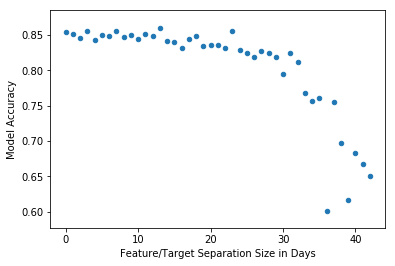

In [29]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)

##  Target Separation Investigation 8 Day Feature Window
Here we will use a constant x window size of 8 days to investigate model accuracy with increasing target separation size

In [21]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('8 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('13 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []


max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7252252252252253
Test model recall: 0.8220551378446115
Test model precision: 0.7454545454545455

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7582582582582582
Test model recall: 0.8471177944862155
Test model precision: 0.771689497716895

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7792792792792793
Test model recall: 0.731829573934837
Test model precision: 0.8795180722891566

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)']
Test mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7069486404833837
Test model recall: 0.8220551378446115
Test model precision: 0.7272727272727273

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7824773413897281
Test model recall: 0.7218045112781954
Test model precision: 0.897196261682243

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.783987915407855
Test model recall: 0.7293233082706767
Test model precision: 0.8926380368098159

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)']
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7257575757575757
Test model recall: 0.8123456790123457
Test model precision: 0.7580645161290323

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7575757575757576
Test model recall: 0.8395061728395061
Test model precision: 0.7816091954022989

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7742424242424243
Test model recall: 0.7061728395061728
Test model precision: 0.9050632911392406

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)']
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7149390243902439
Test model recall: 0.8075949367088607
Test model precision: 0.7418604651162791

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7545731707317073
Test model recall: 0.8430379746835444
Test model precision: 0.7708333333333334

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.788109756097561
Test model recall: 0.7265822784810126
Test model precision: 0.9025157232704403

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)']
Test m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7223926380368099
Test model recall: 0.596401028277635
Test model precision: 0.90625

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7561349693251533
Test model recall: 0.8457583547557841
Test model precision: 0.7686915887850467

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.7791411042944786
Test model recall: 0.7300771208226221
Test model precision: 0.8792569659442725

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%', 'Temp C']
Test model accuracy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.724191063174114
Test model recall: 0.5979643765903307
Test model precision: 0.91796875

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7611710323574731
Test model recall: 0.8473282442748091
Test model precision: 0.7780373831775701

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.7796610169491526
Test model recall: 0.7302798982188295
Test model precision: 0.8858024691358025

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%', 'Temp C']
Test model accur

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7321981424148607
Test model recall: 0.6055979643765903
Test model precision: 0.9296875

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7647058823529411
Test model recall: 0.8447837150127226
Test model precision: 0.7848699763593381

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.7879256965944272
Test model recall: 0.7379134860050891
Test model precision: 0.8950617283950617

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%', 'Temp C']
Test model accur

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7476635514018691
Test model recall: 0.6243386243386243
Test model precision: 0.921875

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7850467289719626
Test model recall: 0.8544973544973545
Test model precision: 0.7955665024630542

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.7975077881619937
Test model recall: 0.783068783068783
Test model precision: 0.8604651162790697

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%', 'Temp C']
Test model accurac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'rainy', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'rainy', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7554858934169278
Test model recall: 0.6322751322751323
Test model precision: 0.93359375

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7884012539184952
Test model recall: 0.8571428571428571
Test model precision: 0.8

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.799373040752351
Test model recall: 0.8095238095238095
Test model precision: 0.8453038674033149

Updating greedy model

Training model with: ['TMIN', 'pH', 'ODOSat%', 'Temp C']
Test model accuracy: 0.79937304

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'Temp C', 'ODOSat%', 'TMAX', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'Temp C', 'ODOSat%', 'TMAX', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7437106918238994
Test model recall: 0.6207792207792208
Test model precision: 0.93359375

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8018867924528302
Test model recall: 0.8389610389610389
Test model precision: 0.834625322997416

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.8018867924528302
Test model recall: 0.8389610389610389
Test model precision: 0.834625322997416

Training model with: ['TMIN', 'pH', 'ODOSat%']
Test model accuracy: 0.7955974842767296
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'Temp C', 'TMAX', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'Temp C', 'TMAX', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7531645569620253
Test model recall: 0.6329787234042553
Test model precision: 0.9296875

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7879746835443038
Test model recall: 0.8297872340425532
Test model precision: 0.8167539267015707

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.7911392405063291
Test model recall: 0.8297872340425532
Test model precision: 0.8210526315789474

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C', 'TMAX']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'pH', 'TMAX', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'pH', 'TMAX', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Turbidity (NTU)', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7722929936305732
Test model recall: 0.6531165311653117
Test model precision: 0.94140625

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7738853503184714
Test model recall: 0.6558265582655827
Test model precision: 0.9416342412451362

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8136942675159236
Test model recall: 0.8130081300813008
Test model precision: 0.8620689655172413

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH', 'TMAX']
Test model accu

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'pH', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'pH', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7728
Test model recall: 0.651595744680851
Test model precision: 0.95703125

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7712
Test model recall: 0.648936170212766
Test model precision: 0.9568627450980393

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.6992
Test model recall: 0.6223404255319149
Test model precision: 0.8357142857142857

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8064
Test model recall: 0.8324468085106383
Test model precision: 0.8436657681940701

Updating greedy m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'pH', 'pH (mV)', 'ODOSat%', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'pH', 'pH (mV)', 'ODOSat%', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'ODO (mg/L)', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7668810289389068
Test model recall: 0.6472148541114059
Test model precision: 0.953125

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7636655948553055
Test model recall: 0.6419098143236074
Test model precision: 0.952755905511811

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7057877813504824
Test model recall: 0.6339522546419099
Test model precision: 0.8415492957746479

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8038585209003215
Test model recall: 0.7851458885941645
Test model p

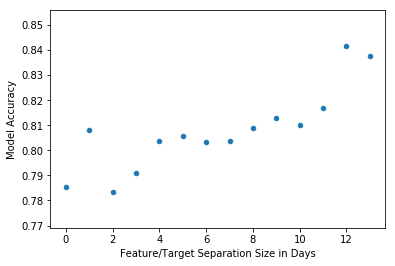

In [22]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)

##  Target Separation Investigation 2 Day Feature Window
Here we will use a constant x window size of 2 days to investigate model accuracy with increasing target separation size

In [23]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('2 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('13 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []


max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
Training model with: ['pH']
Test model accuracy: 0.7215743440233237
Test model recall: 0.8146341463414634
Test model precision: 0.7438752783964365

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.749271137026239
Test model recall: 0.7951219512195122
Test model precision: 0.7874396135265701

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.749271137026239
Test model recall: 0.7926829268292683
Test model precision: 0.7888349514563107

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.746355685131

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
Training model with: ['pH']
Test model accuracy: 0.7339181286549707
Test model recall: 0.8024096385542169
Test model precision: 0.76905311778291

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7675438596491229
Test model recall: 0.7759036144578313
Test model precision: 0.8298969072164949

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7543859649122807
Test model recall: 0.7879518072289157
Test model precision: 0.8034398034398035

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.751461988304

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Wind Speed']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Wind Speed']
Training model with: ['pH']
Test model accuracy: 0.7191176470588235
Test model recall: 0.7902439024390244
Test model precision: 0.7552447552447552

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7602941176470588
Test model recall: 0.7634146341463415
Test model precision: 0.8258575197889182

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7485294117647059
Test model recall: 0.7853658536585366
Test model precision: 0.7950617283950617

Training model with: ['pH', 'ODOSat%', 'TMAX']
Test model accuracy: 0.7544117647058823

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
Training model with: ['pH']
Test model accuracy: 0.7130177514792899
Test model recall: 0.7832512315270936
Test model precision: 0.75

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7544378698224852
Test model recall: 0.8152709359605911
Test model precision: 0.7843601895734598

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7618343195266272
Test model recall: 0.7857142857142857
Test model precision: 0.811704834605598

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'Temp C']
Test model accuracy: 0.7

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'Sp Cond (uS/cm)', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW']
Training model with: ['pH']
Test model accuracy: 0.7191679049034175
Test model recall: 0.7829268292682927
Test model precision: 0.7624703087885986

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.774145616641902
Test model recall: 0.8268292682926829
Test model precision: 0.8071428571428572

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7667161961367014
Test model recall: 0.7804878048780488
Test model precision: 0.8268733850129198

Training model with: ['pH', 'TMIN', 'Temp C']
Test model accuracy: 0.7696879643387816
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7223880597014926
Test model recall: 0.7829268292682927
Test model precision: 0.7679425837320574

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7701492537313432
Test model recall: 0.8146341463414634
Test model precision: 0.8106796116504854

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7731343283582089
Test model recall: 0.7829268292682927
Test model precision: 0.8359375

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'Temp C']
Test model accurac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7192192192192193
Test model recall: 0.7844611528822055
Test model precision: 0.7560386473429952

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7612612612612613
Test model recall: 0.8145363408521303
Test model precision: 0.7926829268292683

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7822822822822822
Test model recall: 0.7994987468671679
Test model precision: 0.8307291666666666

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'TMAX']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7145015105740181
Test model recall: 0.7794486215538847
Test model precision: 0.7548543689320388

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7537764350453172
Test model recall: 0.8070175438596491
Test model precision: 0.7892156862745098

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.783987915407855
Test model recall: 0.7919799498746867
Test model precision: 0.8404255319148937

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'TMAX']
Test model a

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'TMAX', 'Temp C', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7151515151515152
Test model recall: 0.7654320987654321
Test model precision: 0.7692307692307693

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7454545454545455
Test model recall: 0.7950617283950617
Test model precision: 0.7911547911547911

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7787878787878788
Test model recall: 0.7407407407407407
Test model precision: 0.8797653958944281

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'TMAX']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'TMAX', 'ODOSat%', 'Temp C', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'TMIN', 'TMAX', 'ODOSat%', 'Temp C', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7103658536585366
Test model recall: 0.7670886075949367
Test model precision: 0.7556109725685786

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7591463414634146
Test model recall: 0.810126582278481
Test model precision: 0.794044665012407

Updating greedy model

Training model with: ['pH', 'TMIN', 'TMAX']
Test model accuracy: 0.7652439024390244
Test model recall: 0.8278481012658228
Test model precision: 0.7917675544794189

Updating greedy model

Training model with: ['pH', 'TMIN', 'TMAX', 'ODOSat%']
Test model accur

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'TMAX', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'Wind Speed', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'TMAX', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'Wind Speed', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7070552147239264
Test model recall: 0.583547557840617
Test model precision: 0.88671875

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7684049079754601
Test model recall: 0.8097686375321337
Test model precision: 0.8035714285714286

Updating greedy model

Training model with: ['TMIN', 'pH', 'TMAX']
Test model accuracy: 0.7607361963190185
Test model recall: 0.8200514138817481
Test model precision: 0.7876543209876543

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.7684049079754601
Test model re

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH', 'TMAX', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'TMAX', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.711864406779661
Test model recall: 0.5877862595419847
Test model precision: 0.90234375

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.773497688751926
Test model recall: 0.811704834605598
Test model precision: 0.8137755102040817

Updating greedy model

Training model with: ['TMIN', 'pH', 'TMAX']
Test model accuracy: 0.7627118644067796
Test model recall: 0.8193384223918575
Test model precision: 0.7950617283950617

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.7596302003081664
Test model reca

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'pH', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'pH', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['TMIN']
Test model accuracy: 0.7167182662538699
Test model recall: 0.5928753180661578
Test model precision: 0.91015625

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.6702786377708978
Test model recall: 0.5674300254452926
Test model precision: 0.8383458646616542

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7801857585139319
Test model recall: 0.811704834605598
Test model precision: 0.8242894056847545

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.7770897832817337
Test model recall: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'pH', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'pH', 'Temp C', 'ODOSat%', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'rainy', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['TMIN']
Test model accuracy: 0.7414330218068536
Test model recall: 0.6190476190476191
Test model precision: 0.9140625

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.6947040498442367
Test model recall: 0.6084656084656085
Test model precision: 0.8273381294964028

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8021806853582555
Test model recall: 0.8227513227513228
Test model precision: 0.8382749326145552

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.8037383177570093
Test model recall: 

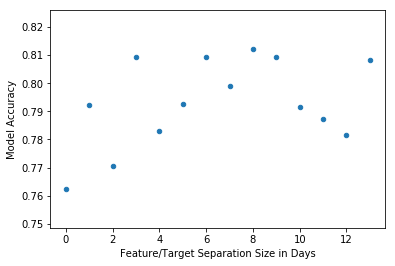

In [24]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)

##  Target Separation Investigation 28 Day Feature Window With Constant Columns
Here we will use a constant x window size of 28 days to investigate model accuracy with increasing target separation size

In [26]:

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('13 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []

base_columns = ['TMIN', 'pH', 'Temp C', 'Wind Speed', 'Sp Cond (uS/cm)',
                'ODO (mg/L)']

max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)

    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
        model, train, test, base_columns,'bloom')
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.8411371237458194
recall 0.896551724137931
precision 0.8578680203045685
cm
 [[165  56]
 [ 39 338]]
current separation 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extr

Combining extractions...

accuracy 0.6582278481012658
recall 0.6436170212765957
precision 0.8148148148148148
cm
 [[122  55]
 [134 242]]


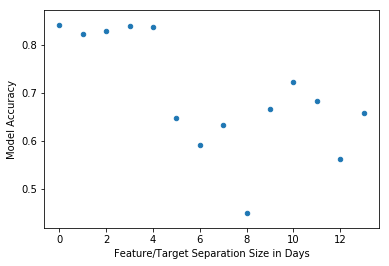

In [27]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)